In [1]:
ls

Aggregation.txt              animation.gif             pogo.ipynb
Aggregation.txt12frames.gif  animation.mp4             R15.txt
Aggregation.txt20frames.gif  Compound.txt              R15.txt22frames.gif
Aggregation.txt22frames.gif  Compound.txt22frames.gif  README.md
Aggregation.txt3frames.gif   D31.txt                   spiral20frames.mp4
animation-400.mp4            D31.txt22frames.gif       spiral40frames.mp4
animation-b.mp4              jain40frames.mp4          spiral.txt
animation-c.mp4              jain.txt                  spiral.txt20frames.gif
animation-d.mp4              jain.txt20frames.gif      spiral.txt5frames.gif


In [2]:
import numpy as np
import pandas as pd
import gudhi

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [4]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import metrics

import os.path

In [5]:
from urllib.request import urlopen
from urllib.parse import urlparse

In [6]:
%matplotlib inline

#randomized blobs with standard deviation
n = 6
std = np.random.random_sample((n,))
#std = 1
X, y, z = make_blobs(
    n_samples=n*100,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)



size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [7]:
urls = ['https://cs.joensuu.fi/sipu/datasets/D31.txt',
        'https://cs.joensuu.fi/sipu/datasets/spiral.txt',
        'https://cs.joensuu.fi/sipu/datasets/overlap.txt',
        'https://cs.joensuu.fi/sipu/datasets/pathbased.txt',
        'https://cs.joensuu.fi/sipu/datasets/a1.txt',
        'https://cs.joensuu.fi/sipu/datasets/R15.txt',
        'https://cs.joensuu.fi/sipu/datasets/unbalance.txt']

In [8]:
url= urls[1]
print(url)
parse = urlparse(url)
filename = parse.path.strip('/').split('/')[-1]
print(filename)
raw_data = urlopen(url)
data = np.loadtxt(raw_data)

print(data.shape)
print(data[:10])


https://cs.joensuu.fi/sipu/datasets/spiral.txt
spiral.txt
(312, 3)
[[31.95  7.95  3.  ]
 [31.15  7.3   3.  ]
 [30.45  6.65  3.  ]
 [29.7   6.    3.  ]
 [28.9   5.55  3.  ]
 [28.05  5.    3.  ]
 [27.2   4.55  3.  ]
 [26.35  4.15  3.  ]
 [25.4   3.85  3.  ]
 [24.6   3.6   3.  ]]


In [9]:
#iris = load_iris()
#X = iris.data
#y = iris.target

In [10]:

y = data[:,2]
print(y.shape)
X = data[:,:2]
print(X.shape)

(312,)
(312, 2)


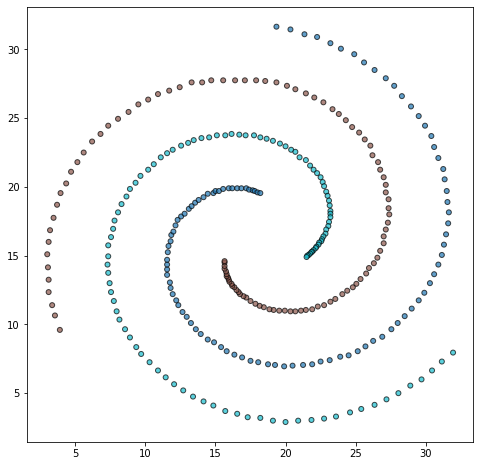

In [11]:
size=8
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [12]:
rips_complex = gudhi.RipsComplex(points=X)

In [13]:
simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
   
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())

312 vertices
48828 simplices
dimension: 1


usetex mode requires TeX.


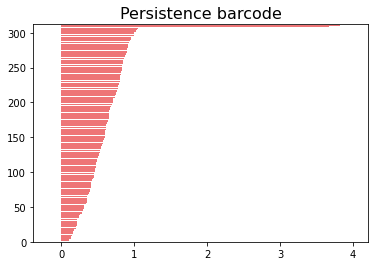

In [14]:
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag)
plt.show()

In [15]:
#move through list and assign clusters to conected components
point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0
cluster_dict_list = []
distance_list = []
for simplex in simplex_tree.get_filtration():
    if len(simplex[0])>1:
        if all(value > 0 for value in list(point_dict.values())):
            if len(np.unique(np.array(list(point_dict.values())))) == 1:
                print('break')
                print(simplex)
                print(simplex[1])
                simplex_tree.prune_above_filtration(simplex[1])
                break


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] == 0:
            counter += 1
            point_dict[simplex[0][0]] = counter
            point_dict[simplex[0][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[simplex[0][0]] == 0 and point_dict[simplex[0][1]] != 0:
            point_dict[simplex[0][0]] = point_dict[simplex[0][1]]

            #and vice versa
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] == 0:
            point_dict[simplex[0][1]] = point_dict[simplex[0][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[simplex[0][0]] != 0 and point_dict[simplex[0][1]] != 0 and point_dict[simplex[0][0]] != point_dict[simplex[0][1]]:
            larger_cluster_number = max(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            smaller_cluster_number = min(point_dict[simplex[0][0]], point_dict[simplex[0][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
                    
        distance_list.append(simplex[1])
        cluster_dict_list.append(point_dict.copy())

break
([78, 90], 3.8209946349085606)
3.8209946349085606


In [16]:
max(distance_list)

3.8209946349085593

In [17]:
len(distance_list)

2190

In [18]:
distance_array = np.array(distance_list)
print(len(distance_array))
distance_array.dtype

2190


dtype('float64')

In [19]:
length = len(cluster_dict_list)
length

2190

In [20]:
print(simplex_tree.num_simplices(), 'simplices')
#?

2504 simplices


In [21]:
#check that all clusters have merged
len(np.unique(np.array(list(point_dict.values()))))

1

In [22]:
#print(cluster_dict_list[-2].values()) #penultimate clustering has 2 clusters
#print(cluster_dict_list[-1].values()) #last clustering finally merges to all one cluster

In [23]:
#find the gaps between birth/death pairs
gaps = np.diff(distance_array)

In [59]:
distance_array.shape

(2190,)

In [57]:
gaps.dtype
gaps.shape

(2189,)

In [66]:
#find normalized distance
scaler = MinMaxScaler()
normed_distance = scaler.fit_transform(distance_array.reshape(-1,1)).T.reshape(length)
normed_distance


array([0.        , 0.00780989, 0.01095723, ..., 0.99930192, 0.99973827,
       1.        ])

In [67]:
#then invert them and multiply by the gaps to weight early connections in the filtration
inverted_normed_distance = 1 - normed_distance
inverted_normed_distance

array([1.00000000e+00, 9.92190106e-01, 9.89042771e-01, ...,
       6.98084873e-04, 2.61725762e-04, 0.00000000e+00])

In [68]:
normed_gaps = np.multiply(gaps, inverted_normed_distance)
normed_gaps

ValueError: operands could not be broadcast together with shapes (2189,) (2190,) 

In [32]:
#normalize to create a probability vector
gap_vector = normed_gaps / np.sum(normed_gaps)

In [33]:
#check
np.sum(gap_vector)

0.9999999999999994

In [34]:
gap_vector

array([[7.31113250e-06, 2.94633701e-06, 3.94912092e-19, ...,
        1.55386879e-06, 4.08491984e-07, 2.45011214e-07],
       [7.25403332e-06, 2.92332643e-06, 3.91827870e-19, ...,
        1.54173324e-06, 4.05301705e-07, 2.43097702e-07],
       [7.23102274e-06, 2.91405332e-06, 3.90584950e-19, ...,
        1.53684269e-06, 4.04016044e-07, 2.42326570e-07],
       ...,
       [5.10379100e-09, 2.05679330e-09, 2.75682158e-22, ...,
        1.08473230e-09, 2.85162075e-10, 1.71038622e-10],
       [1.91351172e-09, 7.71132299e-10, 1.03358668e-22, ...,
        4.06687492e-10, 1.06912876e-10, 6.41257467e-11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

 ...]

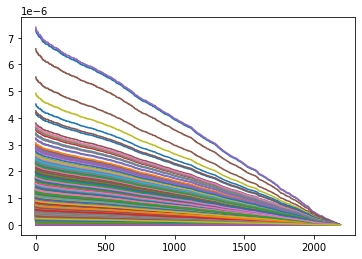

In [29]:
plt.plot(gap_vector)

In [ ]:
marker = 0
for i in range(1,length-1):
    if cluster_dict_list[marker] == cluster_dict_list[i]:

        gap_vector[marker] += gap_vector[i]
        gap_vector[i] = 0
        #print(marker)


    else:
        marker = i

In [ ]:
print(np.sum(gap_vector))
plt.plot(gap_vector)

In [ ]:
candidates = np.flip(np.argsort(gap_vector))

In [ ]:
candidates[0]

In [ ]:
gap_vector[candidates[0]]

In [ ]:
#convert the simplex tree to a pandas dataframe
df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])

In [ ]:
df = df[:len(cluster_dict_list)]
df

In [ ]:
#find the gaps between birth/death pairs
df['gaps'] = df['distance'] - df['distance'].shift(1)

In [ ]:
#find normalized distance
scaler = MinMaxScaler()
df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

In [ ]:
df

In [ ]:
df['inverted_normed_distance'] = 1 - df['normed_distance']

In [ ]:
df

In [ ]:
df['normed_gaps'] = df['gaps'] * df['normed_distance']

In [ ]:
df['inverted_normed_gaps'] = df['gaps'] * df['inverted_normed_distance']

In [ ]:
normed_gap_sum = df['normed_gaps'].sum()
#print(sum)
df['probability_vector'] = df['normed_gaps'] / normed_gap_sum

In [ ]:
inverted_gap_sum = df['inverted_normed_gaps'].sum()
#print(sum)
df['inverted_gap_vector'] = df['inverted_normed_gaps'] / inverted_gap_sum

In [ ]:
gap_sum = df['gaps'].sum()
#print(sum)
df['gap_vector'] = df['gaps'] / gap_sum

In [ ]:
df['probability_vector'][1:]

In [ ]:
sum(df['probability_vector'][1:])

In [ ]:
sum(df['gap_vector'][1:])

In [ ]:
sum(df['inverted_gap_vector'][1:])

In [ ]:
plt.plot(df['probability_vector'])

In [ ]:
plt.plot(df['gap_vector'])

In [ ]:
plt.plot(df['inverted_gap_vector'])

In [ ]:
cluster_dict_list[0].values()

In [ ]:
df.columns

In [ ]:
marker = 0
for i in range(1,length-1):
    if cluster_dict_list[marker] == cluster_dict_list[i]:

        df.iloc[marker,7] += df.iloc[i,7]
        df.iloc[i,7] = 0
                
        df.iloc[marker,8] += df.iloc[i,8]
        df.iloc[i,8] = 0
                
        df.iloc[marker,9] += df.iloc[i,9]
        df.iloc[i,9] = 0
        #print(marker)


    else:
        marker = i

In [ ]:
plt.plot(df['probability_vector'])

In [ ]:
plt.plot(df['gap_vector'])

In [ ]:
plt.plot(df['inverted_gap_vector'])

In [ ]:
candidates = list(df.nlargest(length,['inverted_gap_vector']).index)

In [ ]:
candidates

In [ ]:
idx = candidates[0]
idx

In [ ]:
print(df.loc[:,'gap_vector'][idx])
print('percent confidence')
'{:.1%}'.format(df.loc[:,'gap_vector'][idx])

In [ ]:
np.array(list(cluster_dict_list[idx].values()))

In [ ]:
#cluster_idx_array = (np.unique(np.array(list(cluster_dict_list[idx].values()))))
#print(cluster_idx_array)
#print(np.count_nonzero(cluster_idx_array))

number_of_clusters = np.count_nonzero(np.unique(np.array(list(cluster_dict_list[idx].values()))))
print(number_of_clusters)
print('your dataset appears to have', number_of_clusters,'clusters, not including any outliers')
#return counts from np.unique? to filter out small clusters?

In [ ]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print(metrics.adjusted_rand_score(true, pred))
print(metrics.silhouette_score(X, pred, metric="sqeuclidean"))

In [ ]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='flag',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [ ]:
idx_list = candidates[:50]

In [ ]:
idx_list.sort()

In [ ]:
idx_list = [x for x in idx_list if x < idx]

In [ ]:
idx_array = np.asarray(idx_list)
idx_array

In [ ]:
silhouette_list = []
for i in idx_list:
    silhouette = metrics.silhouette_score(X, np.array(list(cluster_dict_list[i].values())), metric="euclidean")
    silhouette_list.append(silhouette)

In [ ]:
silhouette_array = np.asarray(silhouette_list)

In [ ]:
plt.plot(idx_array,silhouette_array)

In [ ]:
max(silhouette_array)

In [ ]:
max_idx = silhouette_array.argmax()

In [ ]:
idx = idx_array[max_idx]
idx

In [ ]:
#idx = silhouette_scores.index(max(silhouette_scores[simplex_tree.num_vertices():idx]))
#print(idx)

In [ ]:
rand_score_list = []
true = y
for i in idx_list:
    pred = np.array(list(cluster_dict_list[i].values()))
    rand_score = metrics.adjusted_rand_score( true, pred)
    rand_score_list.append(rand_score)

In [ ]:
rand_score_array = np.asarray(rand_score_list)

In [ ]:
 plt.plot(idx_array,rand_score_array)

In [ ]:
max(rand_score_array)

In [ ]:
np.where(rand_score_array == max(rand_score_array) )

In [ ]:
#idx_array[31]

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
frames = len(idx_array)


outfile = filename + str(frames) + 'frames.gif'

if not os.path.isfile(outfile):
    def init():
        scatter = ax.scatter(X[:, 0], X[:, 1],
                        s=40, 
                        c=np.array(list(cluster_dict_list[0].values())),
                        marker="o",
                        cmap='rainbow',
                        norm=None,
                        alpha=1,
                        edgecolor="k")
        #ax.set(xlim=(-1, 35), ylim=(-1, 35))

        return scatter,

    #collection = PatchCollection(X, animated=True)

    #ax.add_collection(collection)
    #ax.autoscale_view(True)

    def animate(i):

        scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[idx_array[i]].values())),
                    marker="o",
                    cmap='flag',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
        return scatter,



    ani = FuncAnimation(fig, animate,interval=200,init_func=init,frames=frames,repeat=False, blit=True)

    #ani.save('animation.gif')



    #writer=animation.PillowWriter()

    #writer = animation.FFMpegWriter(fps=2,bitrate=1000)

    ani.save(outfile, dpi=200)
    fig.show()


In [ ]:
def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices(),len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value - 1
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


In [ ]:
cluster_dict_list, candidates, idx = pogo(X)

In [ ]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


In [ ]:
#%matplotlib notebook

In [ ]:
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
frames = 30
interval = int(len(cluster_dict_list)/frames)
print(interval)

scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[0].values())),
                marker="o",
                cmap='gist_rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
ax.set(xlim=(-1, 35), ylim=(-1, 35))

def animate(n):
    scatter.set_array(np.array(list(cluster_dict_list[n*interval].values())))
    
ani = FuncAnimation(fig, animate,interval=20,frames=frames,repeat=True, blit=True)

#ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=2,bitrate=1000)

ani.save('animation-d.mp4', writer=writer, dpi=250)


fig.show()